In [1]:
from lagrangian import LagrangianSolver
from dataclasses import dataclass

import torch
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rc('font', family='serif', serif="cmr10", size=18)
plt.rc('mathtext', fontset='cm', rm='serif')
plt.rc('axes', unicode_minus=False)

plt.rcParams['axes.formatter.use_mathtext'] = True

# Simple Harmonic Oscilator

In [3]:
@dataclass
class Pendulum(LagrangianSolver):
    m: float        # [kg] mass `m` suspended
    L: float        # [m] at length `L`
    g: float=9.81   # [m/s]

    def T(self, u: torch.Tensor) -> torch.Tensor:
        (t, theta, theta_dot) = u
        return self.m * self.L**2 * theta_dot.square()/2
    
    def V(self, u: torch.Tensor) -> torch.Tensor:
        (t, theta, theta_dot) = u
        return self.m * self.g * theta.square()/2 # use (1-theta.cos()) for no-small angle approx

In [4]:
u0 = (theta0, theta_dot0) = torch.tensor([0.1, 0.0], dtype=torch.float64)

T = 300
N = 30_000
t = torch.linspace(0,T,N)

solver = Pendulum(m=1., L=1.)
soln = solver.solve(u0, t)

100%|██████████| 29999/29999 [01:04<00:00, 466.45it/s]


In [5]:
(u, E) = (soln['u'], soln['E'])

In [6]:
theta0

tensor(0.1000, dtype=torch.float64)

In [7]:
u[:,0]

tensor([ 0.1000,  0.1000,  0.0998,  ..., -0.0988, -0.0983, -0.0977])

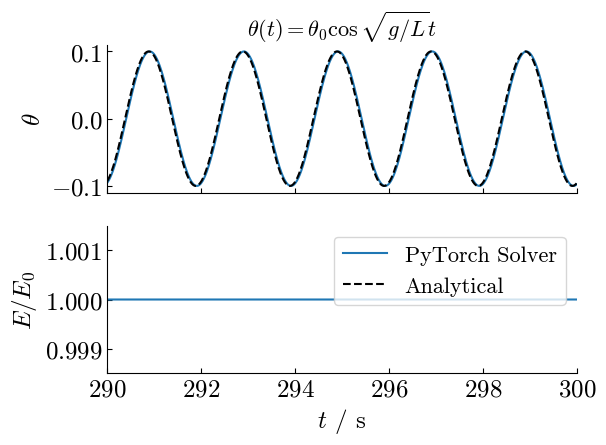

In [8]:
fig, ax = plt.subplots(2, 1, sharex=True)


ax[0].plot(t, u[:,0])
ax[0].plot(t, theta0*torch.cos(math.sqrt(solver.g/solver.L)*t), 'k--')

ax[1].plot(t,E/E[0], label='PyTorch Solver')
ax[1].plot(0,1, 'k--', label='Analytical')

ax[0].set_title(r'$\theta(t)=\theta_0\cos \sqrt{g/L}t$', size=16)
ax[0].set_ylabel(r'$\theta$')
ax[1].set_ylabel(r'$E/E_0$')
ax[1].set_xlabel('$t$ / s')
ax[1].legend(loc='upper right', fontsize=16)
ax[0].set_xlim(290,300)
ax[1].set_yticks([0.999, 1, 1.001])
ax[1].set_ylim(0.9985,1.0015)

fig.tight_layout()
fig.savefig('./assets/SHO.svg')

In [13]:
import numpy as np

t_sub = t[-1000:].detach().numpy()
y_soln = u[:,0][-1000:].detach().numpy()
y_ex = (theta0*np.cos(np.sqrt(solver.g/solver.L)*t_sub)).detach().numpy()

T = 10
fs = len(y_soln) / T

corr = np.correlate(y_soln - np.mean(y_soln), y_ex - np.mean(y_ex), mode='full')

lag = np.argmax(corr) - (len(y_soln) - 1)

# phase-shift
lag/fs

0.01